# Feature Selection

## Libraries and datset:

In [109]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [117]:
# importing dataset
from sklearn.datasets import load_boston

x = load_boston()
df = pd.DataFrame(x.data, columns = x.feature_names)
df["MEDV"] = x.target

X = df.drop("MEDV", 1)   # features
Y = df["MEDV"]           # Target/observations

df.head()

C:\Users\mrb\AppData\Local\Temp/ipykernel_22980/769288740.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop("MEDV", 1)   # features


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## 1- Filter Methods: 
This method just keep subset of relecant features. It contains two steps:

1- Selecting feature with more than 0.5 correlation with target group. (Using Pearson's correlation coefficient)

2- Evaluating correlation between selected features, between two features with high correltio coeficien (higher than 0.5) one of them will be selected 

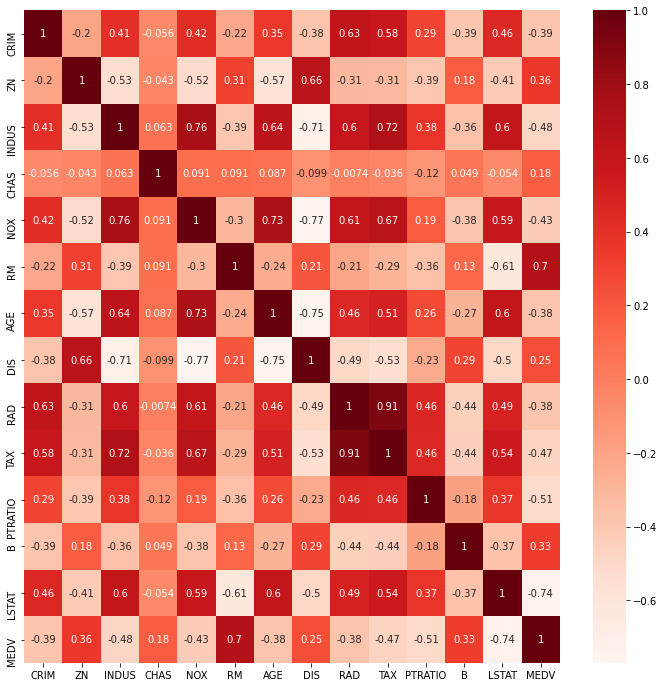

In [56]:
# Pearson's correlation coefficient
plt.figure(figsize=(12,12))
cor = df.corr()
sns.heatmap(cor, annot= True, cmap= plt.cm.Reds)
plt.show()

In [59]:
# 1- Correlation with target group
cor_target = abs(cor["MEDV"])

# Selecting highly correlated features
relevant_features = cor_target[cor_target > 0.5]
relevant_features

RM         0.695360
PTRATIO    0.507787
LSTAT      0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

In [85]:
# 2- Correlation between selected features
print(df[["LSTAT","PTRATIO"]].corr())
print(df[["RM","LSTAT"]].corr())
print(df[["RM","PTRATIO"]].corr())

            LSTAT   PTRATIO
LSTAT    1.000000  0.374044
PTRATIO  0.374044  1.000000
             RM     LSTAT
RM     1.000000 -0.613808
LSTAT -0.613808  1.000000
               RM   PTRATIO
RM       1.000000 -0.355501
PTRATIO -0.355501  1.000000


In [92]:
# All in a function:
def Correlation(dataset, threshold):
    X_corr = list() # all correlated features with target group
    X_selected = list() # finally selected features after evaluating correlation between X_corr features
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        if (abs(corr_matrix.iloc[i,-1]) >= threshold):
            X_corr.append(corr_matrix.columns[i]) # we have the name of features
    X_corr.remove("MEDV")
        
    return X_corr

In [93]:
selected_features_Filter = Correlation(df, 0.5)
print(selected_features_Filter)

['RM', 'PTRATIO', 'LSTAT']


## 2- Wrapper method:
The features be fed to a Machine Learning model and based on the model performance, we can add/remove features.

### I- Backward Elimination:
First all features be fed forward to the model, then the performance will be checked and the in each iteration the features greater than P-value will be eliminated.

Here we used Ordinary Least Squares (OLS) method as performing linear regression.

In [95]:
Selected_features = list(X.columns)
P_max = 1 # P_value

while(len(Selected_features) > 0):
    P_vlaues = []
    # Adding constant column of ones
    X_1 = X[Selected_features]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(Y,X_1).fit() # fitting model on our data
    P_values = pd.Series(model.pvalues.values[1:], index = Selected_features)
    P_max = max(P_values)
    feature_P_max = P_values.idxmax()
    if(P_max > 0.05):
        Selected_features.remove(feature_P_max)
    else:
        break
        
Selected_features_BE = Selected_features
Selected_features_BE

C:\Users\mrb\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\mrb\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\mrb\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


['CRIM',
 'ZN',
 'CHAS',
 'NOX',
 'RM',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

### II. Recursive Feature Elimination (RFE)
 It uses accuracy metric to rank the feature according to their importance.

In [97]:
#no of features
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 10
Score with 10 features: 0.663581


C:\Users\mrb\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\mrb\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\mrb\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\mrb\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_se

In [100]:
selected_features = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 10)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)  
#Fitting the data to model
model.fit(X_rfe,Y)              
temp = pd.Series(rfe.support_,index = selected_features)
selected_features_RFE = temp[temp==True].index
print(selected_features_RFE)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'PTRATIO',
       'LSTAT'],
      dtype='object')


C:\Users\mrb\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


## 3- Embedded method
Takes care of each iteration of the model and selects those features which contribute the most to the training.

### I- Feature selection using LASSO regularization:
If the feature is irrelavant, lasso coefficient is 0 and feature will be redundant.

In [105]:
reg = LassoCV()
reg.fit(X, Y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,Y))
coef = pd.Series(reg.coef_, index = X.columns)
coef

Best alpha using built-in LassoCV: 0.724820
Best score using built-in LassoCV: 0.702444


CRIM      -0.074266
ZN         0.049454
INDUS     -0.000000
CHAS       0.000000
NOX       -0.000000
RM         1.804385
AGE        0.011333
DIS       -0.813244
RAD        0.272284
TAX       -0.015425
PTRATIO   -0.742872
B          0.008926
LSTAT     -0.703654
dtype: float64

In [106]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 10 variables and eliminated the other 3 variables


Text(0.5, 1.0, 'Feature importance using LASSO Model')

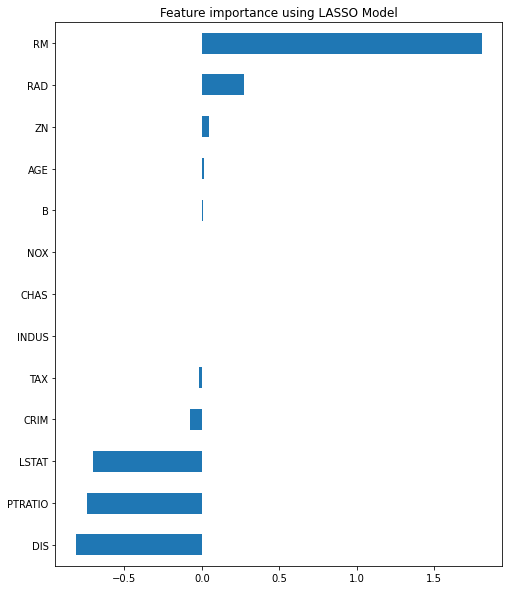

In [126]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using LASSO Model")